<a href="https://colab.research.google.com/github/vankiee/ML_for_data_analysis/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [191]:
import pandas as pd 
from sklearn import metrics, tree
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from io import StringIO
from IPython.display import Image
import pydotplus

# Clean data

In [185]:
df = pd.read_csv('/gapminder.csv')
df[df.columns[1:]] = df.iloc[:, 1:].apply(pd.to_numeric, errors = 'coerce')
dataset = df[df['lifeexpectancy'].notna()]
data_clean = dataset.fillna(0).reset_index(drop = True)
data_clean

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,oilperperson,polityscore,relectricperperson,suicideper100th,employrate,urbanrate
0,Afghanistan,0.000000,0.03,0.569653,26.8,7.594400e+07,25.600000,0.0,3.654122,48.673,0.000000,0.0,0.000000,6.684385,55.700001,24.04
1,Albania,1914.996551,7.29,1.024736,57.4,2.237473e+08,42.099998,0.0,44.989947,76.918,0.000000,9.0,636.341383,7.699330,51.400002,46.72
2,Algeria,2231.993335,0.69,2.306817,23.5,2.932109e+09,31.700001,0.1,12.500073,73.131,0.420095,2.0,590.509814,4.848770,50.500000,65.22
3,Angola,1381.004268,5.57,1.461329,23.1,2.483580e+08,69.400002,2.0,9.999954,51.093,0.000000,-2.0,172.999227,14.554677,75.699997,56.70
4,Argentina,10749.419238,9.35,0.560987,73.9,5.872119e+09,45.900002,0.5,36.000335,75.901,0.635944,8.0,768.428300,7.765584,58.400002,92.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,Vietnam,722.807559,3.91,1.085367,16.2,1.425435e+09,67.599998,0.4,27.851822,75.181,0.000000,-7.0,302.725655,11.653322,71.000000,27.84
187,West Bank and Gaza,0.000000,0.00,5.936085,0.0,1.424133e+07,11.300000,0.0,36.422772,72.832,0.000000,0.0,0.000000,0.000000,32.000000,71.90
188,"Yemen, Rep.",610.357367,0.20,2.316235,35.1,2.348647e+08,20.299999,0.0,12.349750,65.493,0.000000,-2.0,130.057831,6.265789,39.000000,30.64
189,Zambia,432.226337,3.56,0.341335,13.0,1.320257e+08,53.500000,13.5,10.124986,49.025,0.000000,7.0,168.623031,12.019036,61.000000,35.42


In [178]:
data_clean['lifeexpectancy'].quantile([.25, .5, .75])

0.25    64.447
0.50    73.131
0.75    76.593
Name: lifeexpectancy, dtype: float64

In [179]:
data_clean['lifeexpectancy'] = [1 if x >= 76.6 else 0 for x in dataset['lifeexpectancy']]

Since the 3rd quartile is 76.593 years, we set 1 for life expectancy >= 3rd quartile and 0 for anything below.

# Decision Tree

In [180]:
predictors = data_clean[['co2emissions', 'femaleemployrate', 'internetuserate', 'employrate', 
              'urbanrate', 'incomeperperson']]
target = data_clean['lifeexpectancy']

In [181]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target, test_size = .4)
[x.shape for x in [pred_train, pred_test, tar_train, tar_test]]

[(114, 6), (77, 6), (114,), (77,)]

In [186]:
classifier = DecisionTreeClassifier()
classifier = classifier.fit(pred_train, tar_train)

predictions = classifier.predict(pred_test)

confusion_matrix = sklearn.metrics.confusion_matrix(tar_test, predictions)
accuracy_score = sklearn.metrics.accuracy_score(tar_test, predictions)

print('Confusion matrix: \n', confusion_matrix)
print('Accuracy score:', accuracy_score)

Confusion matrix: 
 [[51  5]
 [ 6 15]]
Accuracy score: 0.8571428571428571


# Try cross-validation 

In [183]:
scores = cross_val_score(classifier, predictors, target, cv = 6)
scores

array([0.84375   , 0.875     , 0.9375    , 0.875     , 0.8125    ,
       0.93548387])

In [187]:
predictions2 = cross_val_predict(classifier, predictors, target, cv = 6)
accuracy = metrics.accuracy_score(target, predictions2)
accuracy

0.8638743455497382

Accuracy is better than previous score, but not by much.

# Draw decision tree

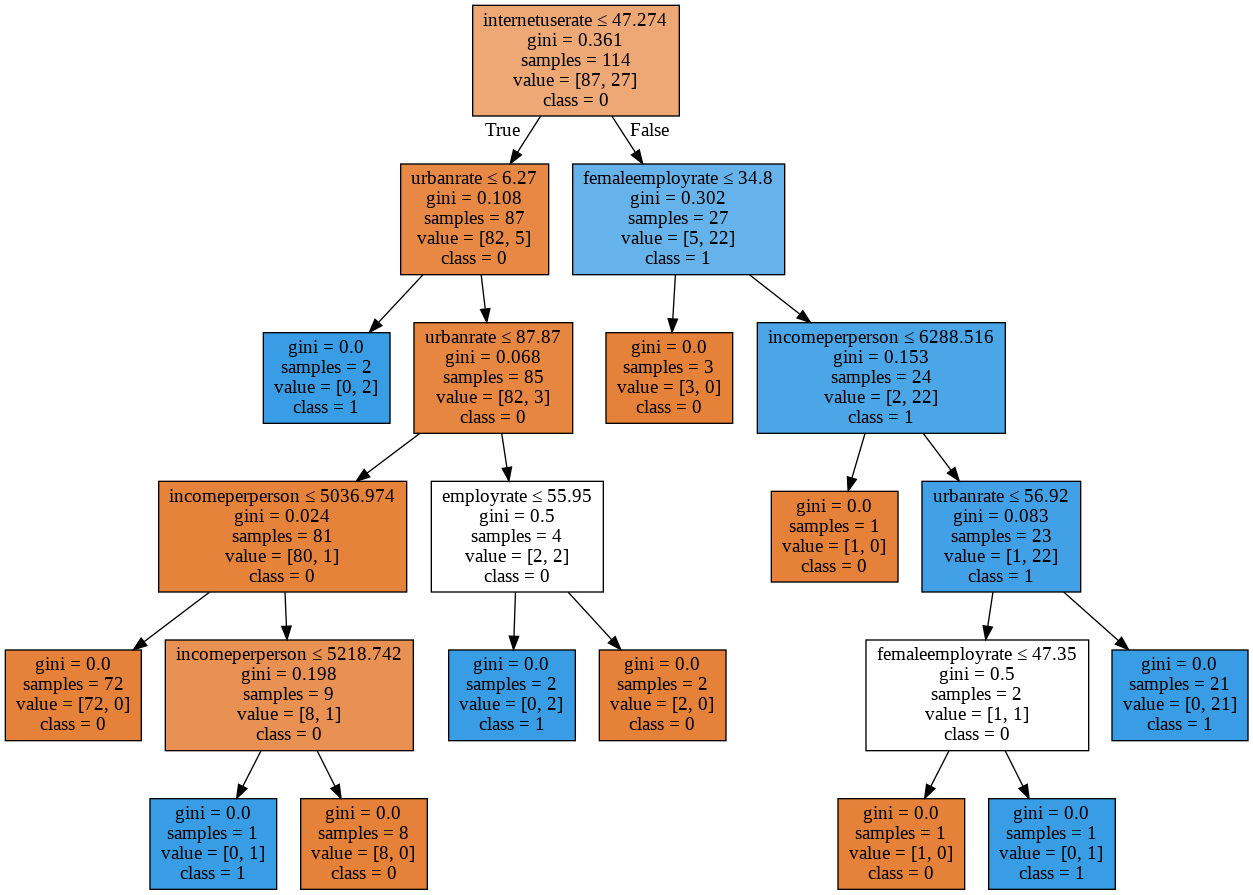

In [210]:
out = StringIO()
tree.export_graphviz(classifier, out_file=out, 
                     filled = True, feature_names = predictors.columns, 
                     class_names = classifier.classes_.astype(str), special_characters = True)
graph = pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png(), width = 700, height = 500)

I will look at cases with sample >= 20 because those seem more credible (e.g. how can countries with high life expectancy have low internet use rate? Or low income per person? Low urban rate is understandable if the country is already developed).

A country has low life expectancy (i.e. < 76.6) if internet use rate < 47.724, urban rate is between 6.27 and 87.87, income per person is less than 5037. 

A country has high life expectancy if internet use rate > 47, female employment rate > 35, income per person > 6289, and urban rate > 56. 

# Areas to improve

1. Fill NaN with mode / median. (So, don't remove 'oilperperson' and 'relectricperperson'.)
2. Standardize features.
3. Better feature selection. (compare relationship between individual variables)
